Rodney Bongcaron <br>
D213 Advance Analytics <br>
July 4, 2022

<h2 style="text-align:center">Performance Assessment: Advance Analytics</h2>
<h3 style="text-align:center">Sentiment Analysis using Neural Networks</h3>

### Part I: Research Question
#### A.  Describe the purpose of this data analysis by doing the following:
1. Will using neural networks and natural language processing indicate whether or not a user's review will be positive or negative on the product or service?
2. The objectives of the analysis is using neural networks and natural language processing to determine if users are in favor of products/services or not.
3. The type of neural network that'll be used is Deep Neural Network (DNN). DNN can be used for text-classification.

### Part II:  Data Preparation
#### B.  Summarize the data cleaning process by doing the following:
1. Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:
    - presence of unusual characters (e.g., emojis, non-English characters, etc.)
    - vocabulary size
    - proposed word embedding length
    - statistical justification for the chosen maximum sequence length

In [612]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras import callbacks
from sklearn.model_selection import train_test_split as tts


from tensorflow import keras # Neural network API
# from keras import preprocessing
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.models import Sequential

import nltk
from nltk.corpus import stopwords # For stopword usage
from nltk import word_tokenize
# from nltk.stem import PorterStermer
# nltk.download ('stopwords')
# nltk.download ('punkt')
# nltk.download ('wordnet')

import warnings
warnings.filterwarnings("ignore")

In [613]:
# importing 3 files
df = pd.read_csv('data/sentiment_label/amazon_labelled.txt', delimiter='\t', header=None)
df.columns = ['Reviews', 'Sentiment']

df_imdb = pd.read_csv('data/sentiment_label/imdb.txt', delimiter='\t', header=None)
df_imdb.columns = ['Reviews', 'Sentiment']

df_yelp = pd.read_csv('data/sentiment_label/yelp_labelled.txt', delimiter='\t', header=None)
df_yelp.columns = ['Reviews', 'Sentiment']


df_list = [df_amz, df_imdb, df_yelp]

# merge all DataFrames into one
df = pd.concat(df_list, ignore_index=True)

pd.set_option('display.max_colwidth', 5000)
df.head()

Reviews  \
0  So there is no way for me to plug it in here in the US unless I go by a converter.   
1                                                         Good case, Excellent value.   
2                                                              Great for the jawbone.   
3     Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!   
4                                                                   The mic is great.   

   Sentiment  
0          0  
1          1  
2          1  
3          0  
4          1

In [614]:
df.shape

(3000, 2)

In [615]:
# Remove Special Characters from a String Using re.sub()
for idx in range(len(df['Reviews'])):
    df['Reviews'][idx] = re.sub("[^a-zA-Z0-9 ]", " ", df['Reviews'][idx]).lower()

df.head()

Reviews  \
0  so there is no way for me to plug it in here in the us unless i go by a converter    
1                                                         good case  excellent value    
2                                                              great for the jawbone    
3     tied to charger for conversations lasting more than 45 minutes major problems     
4                                                                   the mic is great    

   Sentiment  
0          0  
1          1  
2          1  
3          0  
4          1

In [616]:
# Tokenize and finding vocab size
token = Tokenizer()
token.fit_on_texts(df['Reviews'])
vocab_size = len(token.word_index)+1

# word embedding
embed_len = int(round(np.sqrt(np.sqrt(vocab_size)),0))

# finding max length sequence
comment_length = []
for idx in range(len(df['Reviews'])):
    comment_length.append(len(df['Reviews'][idx].split()))

max_len = np.max(comment_length)

print("Vocab size:", vocab_size)
print("Embedded Length:", embed_len)
print("Max Length:", max_len)

Vocab size: 5186
Embedded Length: 8
Max Length: 74


2. Tokenization is the process of breaking up a string into tokens. Commonly, these tokens are words, numbers, and/or punctuation (Tokenizing with TF Text ., n.d.)
<br>
Code provided above.
3. Padding at the end of the reviews to make all sequences the same length as our max sequence.

In [617]:
sequence = token.texts_to_sequences(df['Reviews'])
padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
print(padded,'\n\n', padded[0])

[[ 29  41   6 ...   0   0   0]
 [ 20 158  93 ...   0   0   0]
 [ 23  12   1 ...   0   0   0]
 ...
 [274   3  10 ...   0   0   0]
 [  1 361 165 ...   0   0   0]
 [145  28  48 ...   0   0   0]] 

 [  29   41    6   58  117   12   72    7  372    5   11   65   11    1
  187  579    3   77   63    4 2260    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


4. The values in sentiment are only 0 and 1, positive or negative. In that case the Sigmoid function will be used since it is usually for binary classification.
5. Prepare the data for analysis, including the size of the training, validation, and test set split.

In [618]:
# split data to train and test
X = padded
y = df['Sentiment']

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=7)

# further splitting data with validation
X_train_val, X_val, Y_train_val, Y_val = tts(X_train, y_train, test_size=0.2, random_state=7)

6. Provide a copy of the prepared dataset.

In [619]:
df.to_csv('clean_review_data.csv')

### Part III: Network Architecture
#### C.  Describe the type of network used by doing the following:
1. Model summary of the function from TensorFlow.

In [620]:
# Define a Keras sequential model
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, 16, input_length=max_len))
model.add(keras.layers.GlobalAveragePooling1D())

# Define the first dense layer
model.add(keras.layers.Dense(16, activation='sigmoid'))

# Define the output layer
model.add(keras.layers.Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model architecture
print(model.summary(),'\n')

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 74, 16)            82976     
                                                                 
 global_average_pooling1d_50  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_115 (Dense)           (None, 16)                272       
                                                                 
 dense_116 (Dense)           (None, 1)                 17        
                                                                 
Total params: 83,265
Trainable params: 83,265
Non-trainable params: 0
_________________________________________________________________
None 



2. From the summary of the model. It shows five layers. first layer is the embedding layer with the chosen parameter. Second layer is the GlobalAveragePooling1D function. Third layer is set with a sigmoid activation with 272 parameters. Last layer is set with a sigmoid activation with 17 parameter.
3. Justify the choice of hyperparameters, including the following elements:
    - activation functions
        - Sigmoid is usually used in output layer of a binary classification, where result is either 0 or 1, as value for sigmoid function lies between 0 and 1. (GeeksforGeeks, 2022).
    - number of nodes per layer
        - First layer of nodes is determined by the number of words in the model. Third layer of nodes is an arbitrary number that works fine with the model. Last layer has one node for a binary output. 
    - loss function
        - The loss function is binary_crossentropy, since the sentiments have to output 0 and 1.
    - optimizer
        - Adam optimizer is a gradient descent-based optimizer combined with the advantages of two other optimizers. The method computes the adaptive learning rate for each parameter and applies bias-correction (Understanding Optimizers in Neural Networks with Keras, 2019). 
    - stopping criteria
        - Using the stopping criteria to stop the neural network from overfitting the model.
    - evaluation metric
        - Using accuracy as a metric to evaluate how well the model can classify the data.

### Part IV: Model Evaluation
#### D. Evaluate the model training process and its relevant outcomes by doing the following:
1. Not enough training means that the model will underfit the training and testing sets. Too much training means that the model will overfit the training set and decrease the performance on the testing set. A middle ground is to train the training dataset but stop at a point when performance on a validation dataset starts to decrease. (Brownlee, 2019).

In [622]:
# Define early stopping
early_stopping_monitor = EarlyStopping(patience=2)

# without early stopping
model_1 = model.fit(X_train, y_train, batch_size=32 , epochs=20, validation_data=(X_test, y_test), validation_split=0.3, verbose=True)

Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.5046 - val_loss: 0.6952 - val_accuracy: 0.4817
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5213 - val_loss: 0.6927 - val_accuracy: 0.4817
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6917 - accuracy: 0.5479 - val_loss: 0.6914 - val_accuracy: 0.6333
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.6208 - val_loss: 0.6903 - val_accuracy: 0.5167
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6872 - accuracy: 0.6671 - val_loss: 0.6875 - val_accuracy: 0.7033
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6824 - accuracy: 0.6667 - val_loss: 0.6831 - val_accuracy: 0.7800
Epoch 7/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6750 - accuracy: 0.7554 - val_loss: 0.6771 - val_accuracy: 0.7750
Epoch 8/20
75/75 [==

In [623]:
# final model with early stopping
model_2 = model.fit(X_train, y_train, batch_size=32 , epochs=20, validation_data=(X_test, y_test), validation_split=0.3, callbacks=[early_stopping_monitor], verbose=True)

Epoch 1/20
75/75 [==============================] - 0s 1ms/step - loss: 0.2838 - accuracy: 0.9362 - val_loss: 0.4298 - val_accuracy: 0.8400
Epoch 2/20
75/75 [==============================] - 0s 1ms/step - loss: 0.2610 - accuracy: 0.9396 - val_loss: 0.4196 - val_accuracy: 0.8467
Epoch 3/20
75/75 [==============================] - 0s 1ms/step - loss: 0.2408 - accuracy: 0.9450 - val_loss: 0.4105 - val_accuracy: 0.8450
Epoch 4/20
75/75 [==============================] - 0s 1ms/step - loss: 0.2224 - accuracy: 0.9517 - val_loss: 0.4035 - val_accuracy: 0.8483
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.2074 - accuracy: 0.9575 - val_loss: 0.3974 - val_accuracy: 0.8517
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.9592 - val_loss: 0.3913 - val_accuracy: 0.8483
Epoch 7/20
75/75 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.9658 - val_loss: 0.3933 - val_accuracy: 0.8533
Epoch 8/20
75/75 [==

2. Visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric.

In [624]:
plt.figure(figsize=(15, 5))
plt.plot(model_1.history['val_loss'],label = "val_loss")
plt.plot(model_1.history['loss'],label = "loss")
plt.title('Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()

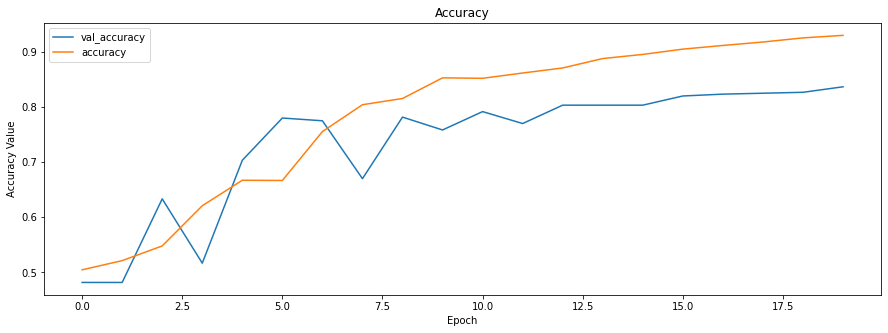

In [625]:
plt.figure(figsize=(15, 5))
plt.plot(model_1.history['val_accuracy'],label = "val_accuracy")
plt.plot(model_1.history['accuracy'],label = "accuracy")
plt.title('Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()

3. There seems to be evidence of overfitting in the model. Ways to address overfitting are implementing a early stopping training, train with more data, data augmentation, etc. (Overfitting, 2021).
4. The final model shows that the accuracy of the training set the last epochs is over 97% and the testing set over 85%. Meaning that the model overall has a high value of predicting the outcome. 

### Part V: Summary and Recommendations
E. Provide the code used to save the trained network within the neural network.

In [626]:
model.save('SentimentAnalysisModel_D213.h5')

F. The Neural Network takes 3000 customer reviews as input to train. Then it uses natural language processing to analyze the sentiments of the customers from the reviews. By training the model, it can predict new customer data if the reviews are positive or negative. This type of neural network is one of the simplest variants of neural networks. It passes information in one direction, through different input nodes, until it makes it to the output node. The network may or may not have hidden node layers, making their functioning more understandable (GeeksforGeeks, 2020c).<br><br>
G. Recommend a course of action based on your results.
G. Based on the results of the model. The model output revealed high accuracy determining whether customer sentiment on reviews would be positive or negative. This can accelerate the process of improving certain products or services in the business to boost customer satisfaction and overall increase retention.

<h2 style="text-align:center">References</h2><br>


Introduction to TensorFlow. (n.d.). DataCamp. Retrieved July 22, 2022, from <br>
<span style="margin-left:2em">https://www.datacamp.com/users/sign_in?redirect=http%3A%2F%2Fapp.datacamp.com%2Flearn%2Fcourses%2Fintroduction-to-tensorflow-in-python</span>

Natural Language Generation. (n.d.). DataCamp. Retrieved July 22, 2022, from <br>
<span style="margin-left:2em">https://www.datacamp.com/users/sign_in?redirect=http%3A%2F%2Fapp.datacamp.com%2Flearn%2Fcourses%2Fnatural-language-generation-in-python</span>

GeeksforGeeks. (2020a, December 11). Combining DataFrames with Pandas. Retrieved July 22, 2022, from <br>
<span style="margin-left:2em">https://www.geeksforgeeks.org/combining-dataframes-with-pandas/</span>

Python: Remove Special Characters from a String. (2022, March 8). Datagy. Retrieved July 22, 2022, from <br>
<span style="margin-left:2em">https://datagy.io/python-remove-special-characters-from-string/</span>

Tokenizing with TF Text. (n.d.). TensorFlow. Retrieved July 22, 2022, from <br>
<span style="margin-left:2em">https://www.tensorflow.org/text/guide/tokenizers</span>

GeeksforGeeks. (2022b, May 18). Activation functions in Neural Networks. Retrieved July 23, 2022, from <br>
<span style="margin-left:2em">https://www.geeksforgeeks.org/activation-functions-neural-networks/</span>

Understanding Optimizers in Neural Networks with Keras. (2019, December 5). DataTechNotes. Retrieved July 24, 2022, from <br> 
<span style="margin-left:2em">https://www.datatechnotes.com/2019/12/understanding-optimizers-in-neural.html</span>

Brownlee, J. (2019, August 6). A Gentle Introduction to Early Stopping to Avoid Overtraining Neural Networks. Machine Learning Mastery. Retrieved July 24, 2022, from <br>
<span style="margin-left:2em">https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/</span>

Overfitting. (2021, March 6). IBM. Retrieved July 24, 2022, from <br>
<span style="margin-left:2em">https://www.ibm.com/cloud/learn/overfitting</span>

GeeksforGeeks. (2020c, July 17). Difference between ANN, CNN and RNN. Retrieved July 24, 2022, from <br>
<span style="margin-left:2em">https://www.geeksforgeeks.org/difference-between-ann-cnn-and-rnn/</span>